In [1]:
!nvidia-smi

Sun Nov  6 13:54:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [ ]:
# install dependents
!pip install monailabel-weekly
!pip install monai
!pip uninstall opencv-contrib-python -y
!pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30
!pip install -q timm
!pip install -U -q openmim
!mim install -U -q mmcv-full

In [9]:
# mount driver
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH


# sync python module
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1jz_DGnICBmKWCr_JL904PDQdIEK0_EQG/CardiacSeg/UNETCNX/CHGH
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Infer

In [25]:
import sys
# set package path
sys.path.append("/content/drive/MyDrive/CardiacSeg")

import os
from pathlib import PurePath

from monai.transforms import LoadImaged

from data_utils.chgh_dataset import get_data_dicts
from data_utils.utils import get_pid_by_file
from data_utils.visualization import show_img_lbl, show_img_lbl_pred

exp_name = 'exp_1_2'
root_dir = '/content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH'

model_name = 'unetcnx'
data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1'
model_dir = os.path.join(root_dir, 'models', exp_name)
infer_dir = os.path.join(root_dir, 'infers', exp_name)
best_checkpoint = os.path.join(model_dir, 'best_model.pth')
#data_dicts_json = os.path.join(root_dir, 'data_dicts', f'{exp_name}.json')

data_dict = get_data_dicts(data_dir)[7]
img_pth = data_dict['image']
lbl_pth = data_dict['label'] 
data_dict['pred'] = os.path.join(infer_dir, PurePath(img_pth).parts[-1])
print(img_pth)
print(lbl_pth)
print(data_dict['pred'])

/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1/pid_110/pid_110.nii.gz
/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1/pid_110/pid_110_gt.nii.gz
/content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH/infers/exp_1_2/pid_110.nii.gz


In [26]:
!python /content/drive/MyDrive/CardiacSeg/expers/chgh/infer.py \
--model_name={model_name} \
--data_dir={data_dir} \
--model_dir={model_dir} \
--infer_dir={infer_dir} \
--checkpoint={best_checkpoint} \
--img_pth={img_pth} \
--lbl_pth={lbl_pth} \
--infer_overlap=0.8

2022-11-06 14:36:06,056 - Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
2022-11-06 14:36:06,074 - Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
cuda is available
model: unetcnx
=> loaded checkpoint '/content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH/models/exp_1_2/best_model.pth')
infer data: {'image': '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1/pid_110/pid_110.nii.gz', 'label': '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1/pid_110/pid_110_gt.nii.gz'}
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor da

# Show result

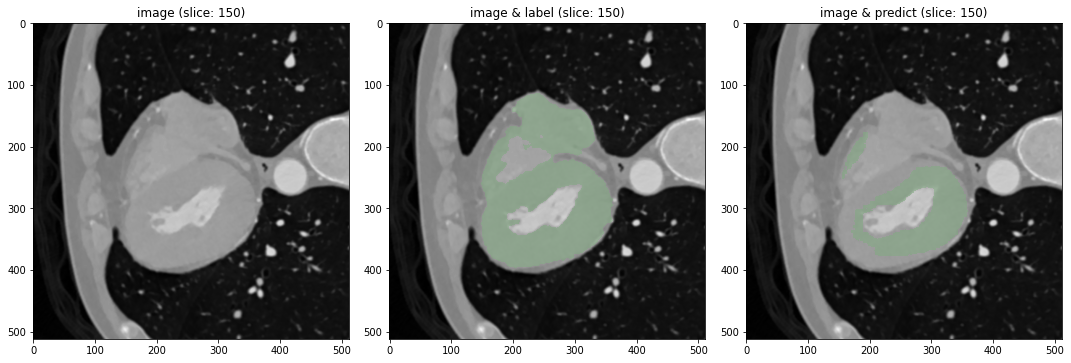

In [27]:
num_classes = 2
slice_idx = 150
alpha = 0.5
axis_off = False
fig_size = (15, 5)

if 'label' in data_dict.keys():
    src_data = LoadImaged(keys=['image', 'label', 'pred'])(data_dict)
    show_img_lbl_pred(
        src_data['image'][:,:,slice_idx],
        src_data['label'][:,:,slice_idx],
        src_data['pred'][:,:,slice_idx],
        slice_idx,
        num_classes, 
        axis_off,
        alpha,
        fig_size
    )
else:
    src_data = LoadImaged(keys=['image', 'pred'])(data_dict)
    show_img_lbl(
        src_data['image'][:,:,slice_idx],
        src_data['pred'][:,:,slice_idx],
        slice_idx,
        num_classes, 
        axis_off,
        alpha,
        fig_size
    )

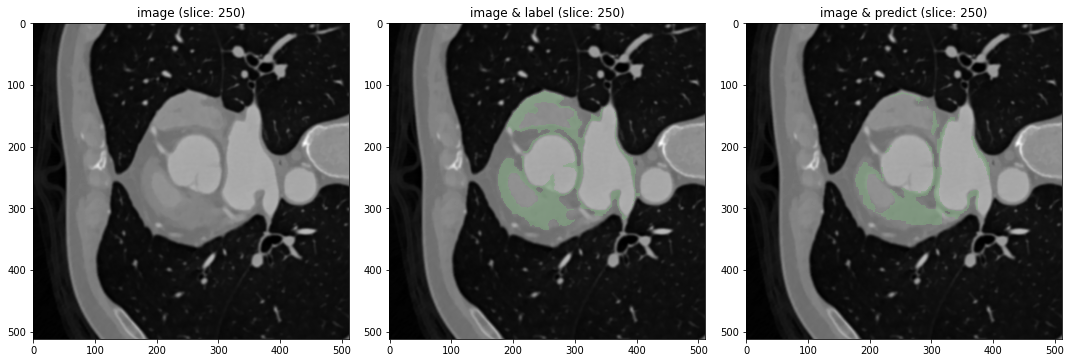

In [28]:
slice_idx = 250
show_img_lbl_pred(
        src_data['image'][:,:,slice_idx],
        src_data['label'][:,:,slice_idx],
        src_data['pred'][:,:,slice_idx],
        slice_idx,
        num_classes, 
        axis_off,
        alpha,
        fig_size
    )